In [231]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl
from datetime import datetime
import json

In [232]:
store_100_path = r"df_all_store_100.parquet"
store_42_path = r"df_all_store_42.parquet"
# store_4906_path = r"C:\Users\yotam\SDatta\fashion\stores_data\df_all_store_4906.parquet"

In [233]:
pl.Config.set_fmt_str_lengths(314)
pl.Config.set_tbl_cols(20)
pl.Config.set_tbl_rows(314)

polars.config.Config

In [234]:
df_100 = pl.read_parquet(store_100_path).drop(columns=["__index_level_0__"])
df_all = df_100.clone()

In [235]:
del df_100

In [236]:
df_42 = pl.read_parquet(store_42_path).drop(columns=["__index_level_0__"])

In [237]:
df_all = pl.concat([df_all, df_42])

In [238]:
del df_42

In [239]:
# df_4906 = pl.read_parquet(store_4906_path).drop(columns=["__index_level_0__"])

In [240]:
# df_all = pl.concat([df_all, df_4906])

In [241]:
# del df_4906

In [242]:
print(f"Memory usage of dataframe is df_all {round(df_all.estimated_size('mb'), 2)} MB")

Memory usage of dataframe is df_all 6206.84 MB


# read data from warehouse

In [243]:
waerhouse_path = r"df_all_store_VZ01.parquet"
df_warehouse = pl.read_parquet(waerhouse_path).drop(columns=["__index_level_0__"])

In [244]:
df_warehouse = df_warehouse.with_columns(pl.col('sku').cast(pl.Utf8))

In [245]:
df_warehouse = df_warehouse.rename({"stock": "warehouse_stock"})

# join data

In [246]:
df_step1 = df_all.join(df_warehouse[["sku","date","warehouse_stock"]], on = ["sku","date"], how = "left")

In [247]:
df_step1 = df_step1.with_columns(pl.col('warehouse_stock').fill_null(0))

In [248]:
df_step1 = df_step1.sort(['sku',"store",'date'])

In [249]:
df_step1 =df_step1.with_columns((pl.col("warehouse_stock").diff().over(["store","sku"]).alias("warehouse_stock_change").fill_nan(0)))

In [250]:
df_step1 = df_step1.with_columns(pl.col('stock').diff().over(["store","sku"]).alias("stock_change").fill_nan(0))

In [251]:
del df_all, df_warehouse

In [252]:
filtered_df_stock = df_step1.filter(pl.col('stock') > 0)
result_df_stock_non_zeros = filtered_df_stock.with_columns(pl.col('stock').first().over(["store","sku"]).alias("first_stock"))

# read dict of stores distribution

In [253]:
dict_per_store_per_year_path = r"dict_per_store_per_year.json"
with open(dict_per_store_per_year_path) as json_file:
    dict_per_store_per_year = json.load(json_file)

In [254]:
dict_per_store_per_year_2022 = dict_per_store_per_year["2022"]

# view

In [255]:
print(df_step1.shape)

(54196055, 12)


In [256]:
dict_per_store_per_year_2022["100"], dict_per_store_per_year_2022["42"]

(0.037152098092696574, 0.02105508186996078)

In [257]:
print(df_step1.head(30))

shape: (30, 12)
┌────────┬───────┬────────┬────────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┐
│ sku    ┆ store ┆ date   ┆ averag ┆ avera ┆ sales ┆ item  ┆ sku_s ┆ stock ┆ wareh ┆ wareh ┆ stock │
│ ---    ┆ ---   ┆ ---    ┆ e_pric ┆ ge_di ┆ ---   ┆ ---   ┆ tore  ┆ ---   ┆ ouse_ ┆ ouse_ ┆ _chan │
│ str    ┆ str   ┆ dateti ┆ e      ┆ count ┆ f64   ┆ str   ┆ ---   ┆ f64   ┆ stock ┆ stock ┆ ge    │
│        ┆       ┆ me[ns] ┆ ---    ┆ ed_pr ┆       ┆       ┆ str   ┆       ┆ ---   ┆ _chan ┆ ---   │
│        ┆       ┆        ┆ f64    ┆ ice   ┆       ┆       ┆       ┆       ┆ f64   ┆ ge    ┆ f64   │
│        ┆       ┆        ┆        ┆ ---   ┆       ┆       ┆       ┆       ┆       ┆ ---   ┆       │
│        ┆       ┆        ┆        ┆ f64   ┆       ┆       ┆       ┆       ┆       ┆ f64   ┆       │
╞════════╪═══════╪════════╪════════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╡
│ 100009 ┆ 100   ┆ 2018-0 ┆ null   ┆ null  ┆ 0.0   ┆ 10000 ┆ 10000 ┆ 0.0   

In [258]:
max_sku_temp = 100630105000002

In [259]:
sku_temp = df_step1.filter((pl.col('sku').is_in(100630105000002))).select(pl.col(["date","stock",'warehouse_stock_change',"sales","stock_change","store","warehouse_stock"]))

In [260]:
stock_init_warehouse_sku = sku_temp.with_columns(pl.col('warehouse_stock').first().over(["store"]).alias("first_stock"))

In [261]:
print(stock_init_warehouse_sku.filter(pl.col("store")=="100").select(pl.col(["first_stock"])).max()[0,0])

3165.0


In [262]:
dict_per_store_per_year_2022["100"]

0.037152098092696574

In [263]:
dict_per_store_per_year_2022["100"] * stock_init_warehouse_sku.filter(pl.col("store")=="100").select(pl.col(["first_stock"])).max()[0,0]

117.58639046338466

In [264]:
dict_per_store_per_year["2020"]["100"] * stock_init_warehouse_sku.filter(pl.col("store")=="100").select(pl.col(["first_stock"])).max()[0,0]

102.88225467315803

In [265]:
dict_per_store_per_year["2019"]["100"] * stock_init_warehouse_sku.filter(pl.col("store")=="100").select(pl.col(["first_stock"])).max()[0,0]

133.5723185928597

In [266]:
dict_per_store_per_year_2022["42"] * stock_init_warehouse_sku.filter(pl.col("store")=="42").select(pl.col(["first_stock"])).max()[0,0]

66.63933411842586

In [267]:
dict_per_store_per_year["2020"]["42"] * stock_init_warehouse_sku.filter(pl.col("store")=="42").select(pl.col(["first_stock"])).max()[0,0]

58.52620685217021

In [268]:
dict_per_store_per_year["2019"]["42"] * stock_init_warehouse_sku.filter(pl.col("store")=="42").select(pl.col(["first_stock"])).max()[0,0]

57.19070811057481

In [269]:
dict_per_store_per_year["2018"]["42"] * stock_init_warehouse_sku.filter(pl.col("store")=="42").select(pl.col(["first_stock"])).max()[0,0]

59.36505388212157

In [270]:
print(sku_temp.filter(pl.col("store")=="100").select(pl.col(["sales"])).sum())

shape: (1, 1)
┌───────┐
│ sales │
│ ---   │
│ f64   │
╞═══════╡
│ 51.0  │
└───────┘


In [271]:
print(sku_temp.filter(pl.col("store")=="42").select(pl.col(["sales"])).sum())

shape: (1, 1)
┌───────┐
│ sales │
│ ---   │
│ f64   │
╞═══════╡
│ 53.0  │
└───────┘


In [272]:
print(sku_temp.filter(pl.col("store")=="100").filter(pl.col('stock_change')<0).sum())

shape: (1, 7)
┌──────────────┬───────┬────────────────────────┬───────┬──────────────┬───────┬─────────────────┐
│ date         ┆ stock ┆ warehouse_stock_change ┆ sales ┆ stock_change ┆ store ┆ warehouse_stock │
│ ---          ┆ ---   ┆ ---                    ┆ ---   ┆ ---          ┆ ---   ┆ ---             │
│ datetime[ns] ┆ f64   ┆ f64                    ┆ f64   ┆ f64          ┆ str   ┆ f64             │
╞══════════════╪═══════╪════════════════════════╪═══════╪══════════════╪═══════╪═════════════════╡
│ null         ┆ 370.0 ┆ -276.0                 ┆ 13.0  ┆ -53.0        ┆ null  ┆ 9589.0          │
└──────────────┴───────┴────────────────────────┴───────┴──────────────┴───────┴─────────────────┘


In [273]:
print(sku_temp.filter(pl.col("store")=="42").filter(pl.col('stock_change')<0).sum())

shape: (1, 7)
┌──────────────┬───────┬────────────────────────┬───────┬──────────────┬───────┬─────────────────┐
│ date         ┆ stock ┆ warehouse_stock_change ┆ sales ┆ stock_change ┆ store ┆ warehouse_stock │
│ ---          ┆ ---   ┆ ---                    ┆ ---   ┆ ---          ┆ ---   ┆ ---             │
│ datetime[ns] ┆ f64   ┆ f64                    ┆ f64   ┆ f64          ┆ str   ┆ f64             │
╞══════════════╪═══════╪════════════════════════╪═══════╪══════════════╪═══════╪═════════════════╡
│ null         ┆ 442.0 ┆ -381.0                 ┆ 7.0   ┆ -55.0        ┆ null  ┆ 13714.0         │
└──────────────┴───────┴────────────────────────┴───────┴──────────────┴───────┴─────────────────┘


In [274]:
# sku_temp.filter(pl.col("store")=="42").select(pl.col(["date","stock",'warehouse_stock_change',"sales","stock_change","store","warehouse_stock"]))

# dict compare dist caculation to actual from sales

In [275]:
stock_init_warehouse_sku = df_step1.filter(pl.col("warehouse_stock")>0).groupby(["sku"]).agg(pl.col("warehouse_stock").first().alias("total_stock_from_warehouse"))

/var/folders/sv/p02my_xx7t193mwjyb2ytt040000gn/T/ipykernel_25094/855338996.py:1: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  stock_init_warehouse_sku = df_step1.filter(pl.col("warehouse_stock")>0).groupby(["sku"]).agg(pl.col("warehouse_stock").first().alias("total_stock_from_warehouse"))


In [276]:
their_suggestion_stock_init = df_step1.filter(pl.col("stock")>0).groupby(["sku"]).agg(pl.col("stock").first().alias("palmers_suggest_stock_init"))

/var/folders/sv/p02my_xx7t193mwjyb2ytt040000gn/T/ipykernel_25094/3744170835.py:1: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  their_suggestion_stock_init = df_step1.filter(pl.col("stock")>0).groupby(["sku"]).agg(pl.col("stock").first().alias("palmers_suggest_stock_init"))


In [277]:
df_step1.filter(pl.col("sku")=="100090841000004")

sku,store,date,average_price,average_dicounted_price,sales,item,sku_store,stock,warehouse_stock,warehouse_stock_change,stock_change
str,str,datetime[ns],f64,f64,f64,str,str,f64,f64,f64,f64
"""100090841000004""","""100""",2017-12-20 00:00:00,null,null,0.0,"""100090841000""","""100090841000004,100""",4.0,0.0,null,null
"""100090841000004""","""100""",2017-12-21 00:00:00,null,null,0.0,"""100090841000""","""100090841000004,100""",4.0,0.0,0.0,0.0
"""100090841000004""","""100""",2017-12-22 00:00:00,null,null,0.0,"""100090841000""","""100090841000004,100""",4.0,0.0,0.0,0.0
"""100090841000004""","""100""",2017-12-23 00:00:00,null,null,0.0,"""100090841000""","""100090841000004,100""",4.0,0.0,0.0,0.0
"""100090841000004""","""100""",2017-12-24 00:00:00,null,null,0.0,"""100090841000""","""100090841000004,100""",4.0,0.0,0.0,0.0
"""100090841000004""","""100""",2017-12-25 00:00:00,null,null,0.0,"""100090841000""","""100090841000004,100""",4.0,0.0,0.0,0.0
"""100090841000004""","""100""",2017-12-26 00:00:00,null,null,0.0,"""100090841000""","""100090841000004,100""",4.0,0.0,0.0,0.0
"""100090841000004""","""100""",2017-12-27 00:00:00,null,null,0.0,"""100090841000""","""100090841000004,100""",4.0,0.0,0.0,0.0
"""100090841000004""","""100""",2017-12-28 00:00:00,null,null,0.0,"""100090841000""","""100090841000004,100""",4.0,0.0,0.0,0.0


In [278]:
print(stock_init_warehouse_sku.head(3))

shape: (3, 2)
┌─────────────────┬────────────────────────────┐
│ sku             ┆ total_stock_from_warehouse │
│ ---             ┆ ---                        │
│ str             ┆ f64                        │
╞═════════════════╪════════════════════════════╡
│ 100648051000001 ┆ 261.0                      │
│ 100618083000004 ┆ 2.0                        │
│ 100648054000006 ┆ 660.0                      │
└─────────────────┴────────────────────────────┘


In [279]:
stock_init_warehouse_sku.groupby(["sku"]).agg(pl.col("total_stock_from_warehouse").sum())["sku"]

/var/folders/sv/p02my_xx7t193mwjyb2ytt040000gn/T/ipykernel_25094/4049317997.py:1: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  stock_init_warehouse_sku.groupby(["sku"]).agg(pl.col("total_stock_from_warehouse").sum())["sku"]


sku
str
"""100633289000010"""
"""100633220000001"""
"""100090861000004"""
"""100643105000010"""
"""100652027000001"""
"""100552812000002"""
"""100654036000002"""
"""100628375000006"""
"""100618301000007"""


In [280]:
stock_init_warehouse_sku.groupby(["sku"]).agg(pl.col("total_stock_from_warehouse").sum())

/var/folders/sv/p02my_xx7t193mwjyb2ytt040000gn/T/ipykernel_25094/125524530.py:1: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  stock_init_warehouse_sku.groupby(["sku"]).agg(pl.col("total_stock_from_warehouse").sum())


sku,total_stock_from_warehouse
str,f64
"""100528025000011""",245.0
"""100553956000003""",289.0
"""100510584000011""",1757.0
"""100618204000005""",546.0
"""100610050000002""",1505.0
"""100653209000001""",411.0
"""100653091000003""",146.0
"""100618338000007""",566.0
"""100548381000002""",131.0


In [281]:
temp_100_weighted = stock_init_warehouse_sku.groupby(["sku"]).agg(dict_per_store_per_year["2020"]["100"] * pl.col("total_stock_from_warehouse").sum()).to_pandas()
temp_42_weighted = stock_init_warehouse_sku.groupby(["sku"]).agg(dict_per_store_per_year["2020"]["42"] * pl.col("total_stock_from_warehouse").sum()).to_pandas()

/var/folders/sv/p02my_xx7t193mwjyb2ytt040000gn/T/ipykernel_25094/2757386023.py:1: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  temp_100_weighted = stock_init_warehouse_sku.groupby(["sku"]).agg(dict_per_store_per_year["2020"]["100"] * pl.col("total_stock_from_warehouse").sum()).to_pandas()
/var/folders/sv/p02my_xx7t193mwjyb2ytt040000gn/T/ipykernel_25094/2757386023.py:2: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  temp_42_weighted = stock_init_warehouse_sku.groupby(["sku"]).agg(dict_per_store_per_year["2020"]["42"] * pl.col("total_stock_from_warehouse").sum()).to_pandas()


In [282]:
temp_100_= stock_init_warehouse_sku.groupby(["sku"]).agg( pl.col("total_stock_from_warehouse").sum()).to_pandas()
temp_42_= stock_init_warehouse_sku.groupby(["sku"]).agg( pl.col("total_stock_from_warehouse").sum()).to_pandas()

/var/folders/sv/p02my_xx7t193mwjyb2ytt040000gn/T/ipykernel_25094/3277643327.py:1: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  temp_100_= stock_init_warehouse_sku.groupby(["sku"]).agg( pl.col("total_stock_from_warehouse").sum()).to_pandas()
/var/folders/sv/p02my_xx7t193mwjyb2ytt040000gn/T/ipykernel_25094/3277643327.py:2: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  temp_42_= stock_init_warehouse_sku.groupby(["sku"]).agg( pl.col("total_stock_from_warehouse").sum()).to_pandas()


In [283]:
temp_100_palmers = their_suggestion_stock_init.groupby(["sku"]).agg( pl.col("palmers_suggest_stock_init").sum()).to_pandas()
temp_42_palmers = their_suggestion_stock_init.groupby(["sku"]).agg( pl.col("palmers_suggest_stock_init").sum()).to_pandas()

/var/folders/sv/p02my_xx7t193mwjyb2ytt040000gn/T/ipykernel_25094/2572937343.py:1: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  temp_100_palmers = their_suggestion_stock_init.groupby(["sku"]).agg( pl.col("palmers_suggest_stock_init").sum()).to_pandas()
/var/folders/sv/p02my_xx7t193mwjyb2ytt040000gn/T/ipykernel_25094/2572937343.py:2: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  temp_42_palmers = their_suggestion_stock_init.groupby(["sku"]).agg( pl.col("palmers_suggest_stock_init").sum()).to_pandas()


In [284]:
temp_100_our = stock_init_warehouse_sku.groupby(["sku"]).agg((dict_per_store_per_year["2020"]["100"] * pl.col("total_stock_from_warehouse").sum()*1/3).round(0)).to_pandas()
temp_42_our = stock_init_warehouse_sku.groupby(["sku"]).agg((dict_per_store_per_year["2020"]["42"] * pl.col("total_stock_from_warehouse").sum()*1/3).round(0)).to_pandas()

/var/folders/sv/p02my_xx7t193mwjyb2ytt040000gn/T/ipykernel_25094/672671330.py:1: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  temp_100_our = stock_init_warehouse_sku.groupby(["sku"]).agg((dict_per_store_per_year["2020"]["100"] * pl.col("total_stock_from_warehouse").sum()*1/3).round(0)).to_pandas()
/var/folders/sv/p02my_xx7t193mwjyb2ytt040000gn/T/ipykernel_25094/672671330.py:2: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  temp_42_our = stock_init_warehouse_sku.groupby(["sku"]).agg((dict_per_store_per_year["2020"]["42"] * pl.col("total_stock_from_warehouse").sum()*1/3).round(0)).to_pandas()


In [285]:
# temp_100_our.with_columns(pl.col("store").fill_null("100"))
# temp_42_our.with_columns(pl.col("store").fill_null("42"))

In [286]:
temp_42_our[temp_42_our['sku'] == '100630105000002']

,sku,literal
5203,100630105000002,20.0


In [287]:
temp_100_our[temp_100_our['sku'] == '100630105000002']

,sku,literal
12952,100630105000002,34.0


In [288]:
sales_100 = df_step1.filter(pl.col("store")=="100").groupby(["sku"]).agg(pl.col("sales").sum()).to_pandas()
sales_42 = df_step1.filter(pl.col("store")=="42").groupby(["sku"]).agg(pl.col("sales").sum()).to_pandas()

/var/folders/sv/p02my_xx7t193mwjyb2ytt040000gn/T/ipykernel_25094/547613853.py:1: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  sales_100 = df_step1.filter(pl.col("store")=="100").groupby(["sku"]).agg(pl.col("sales").sum()).to_pandas()
/var/folders/sv/p02my_xx7t193mwjyb2ytt040000gn/T/ipykernel_25094/547613853.py:2: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  sales_42 = df_step1.filter(pl.col("store")=="42").groupby(["sku"]).agg(pl.col("sales").sum()).to_pandas()


In [289]:
temp_100_our['store'] = "100"
temp_42_our['store'] = "42"
temp_42_100_our = pd.concat([temp_100_our, temp_42_our])


In [290]:
temp_42_our

,sku,literal,store
0,100618362000002,3.0,42
1,100653532000012,2.0,42
2,100553993000001,4.0,42
3,100610018000004,1.0,42
4,100082032000002,6.0,42
...,...,...,...
21962,100657008000001,2.0,42
21963,100653273000005,2.0,42
21964,100080083000001,5.0,42
21965,100552518000001,2.0,42


In [291]:
df_step1 = df_step1.to_pandas()

In [292]:
df_step1 = df_step1.merge(temp_42_100_our, on = ["sku", 'store'], how = "left")

In [293]:
df_step1 = df_step1.rename(columns={"literal": "our_first_allocation"})

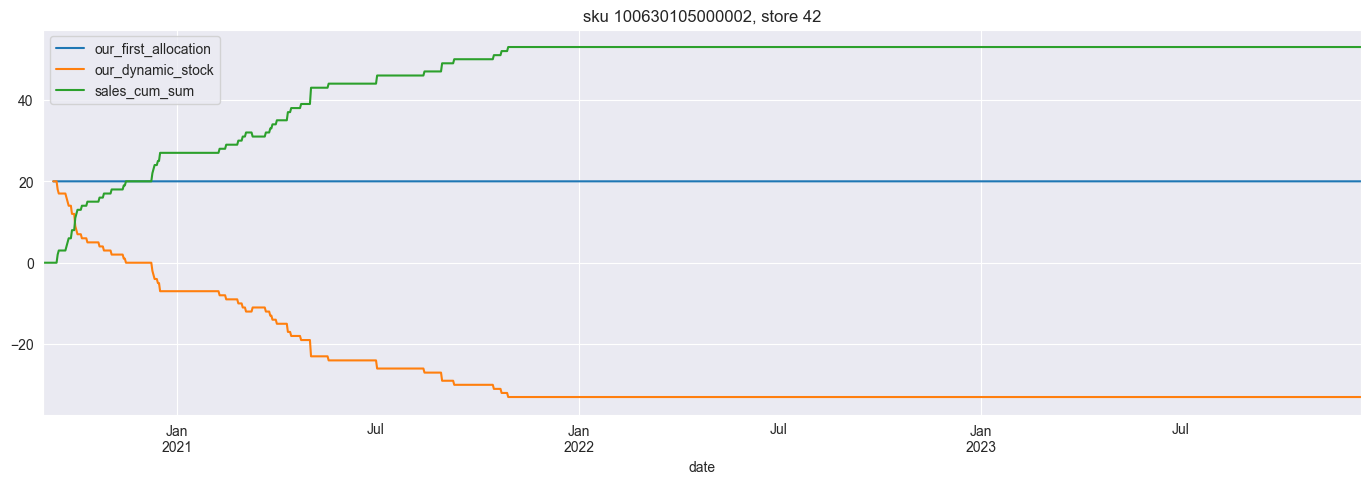

In [338]:
#import plt
import warnings
warnings.filterwarnings('ignore')
df_step1['date'] = pd.to_datetime(df_step1['date'])
import matplotlib.pyplot as plt

for sku in ['100630105000002']:
    for store in ['42']:
        sku_store_df_step = df_step1[(df_step1["sku"]==sku) & (df_step1["store"]==store)]
        # find in stock the first time that is not zero
        first_stock = sku_store_df_step[sku_store_df_step["stock"]>0]["stock"].iloc[0]
        # nan in our_first_allocation if before first stock
        sku_store_df_step.loc[sku_store_df_step["date"]<sku_store_df_step[sku_store_df_step["stock"]>0]["date"].iloc[0], "our_first_allocation"] = np.nan
        # add number of days from first stock 1 2 3 4 5 6 7 8 9 10
        sku_store_df_step['days_from_first_stock'] = np.nan
        sku_store_df_step.loc[sku_store_df_step["date"]>=sku_store_df_step[sku_store_df_step["stock"]>0]["date"].iloc[0], "days_from_first_stock"] = sku_store_df_step[sku_store_df_step["date"]>=sku_store_df_step[sku_store_df_step["stock"]>0]["date"].iloc[0]].index - sku_store_df_step[sku_store_df_step["stock"]>0].index[0]

        sku_store_df_step['sales_cum_sum'] = sku_store_df_step['sales'].cumsum()
        sku_store_df_step['sales_normalized_by_days'] = sku_store_df_step['sales_cum_sum'] / sku_store_df_step['days_from_first_stock']
        sku_store_df_step['our_dynamic_stock'] = sku_store_df_step['our_first_allocation'] - sku_store_df_step['sales_cum_sum']
        sku_store_df_step.set_index('date')[['our_first_allocation','our_dynamic_stock', 'sales_cum_sum']].plot(figsize=(17, 5))
        plt.title(f"sku {sku}, store {store}")
        plt.show()


In [339]:
sku_store_df_step.iloc[:50]

,sku,store,date,average_price,average_dicounted_price,sales,item,sku_store,stock,warehouse_stock,warehouse_stock_change,stock_change,our_first_allocation,days_from_first_stock,sales_cum_sum,sales_normalized_by_days,our_dynamic_stock
41584968,100630105000002,42,2020-09-02,NaN,NaN,0.0,100630105000,"100630105000002,42",0.0,3165.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN
41584969,100630105000002,42,2020-09-03,NaN,NaN,0.0,100630105000,"100630105000002,42",0.0,3165.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN
41584970,100630105000002,42,2020-09-04,NaN,NaN,0.0,100630105000,"100630105000002,42",0.0,3165.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN
41584971,100630105000002,42,2020-09-05,NaN,NaN,0.0,100630105000,"100630105000002,42",0.0,3165.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN
41584972,100630105000002,42,2020-09-06,NaN,NaN,0.0,100630105000,"100630105000002,42",0.0,3165.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN
41584973,100630105000002,42,2020-09-07,NaN,NaN,0.0,100630105000,"100630105000002,42",0.0,3165.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN
41584974,100630105000002,42,2020-09-08,NaN,NaN,0.0,100630105000,"100630105000002,42",0.0,3165.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN
41584975,100630105000002,42,2020-09-09,NaN,NaN,0.0,100630105000,"100630105000002,42",0.0,3165.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN
41584976,100630105000002,42,2020-09-10,NaN,NaN,0.0,100630105000,"100630105000002,42",0.0,3165.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN
41584977,100630105000002,42,2020-09-11,NaN,NaN,0.0,100630105000,"100630105000002,42",20.0,2203.0,-962.0,20.0,20.0,0.0,0.0,NaN,20.0


In [319]:
sku_store_df_step.set_index('date')[['stock', 'our_first_allocation', 'sales', 'our_dynamic_stock']]

,stock,our_first_allocation,sales,our_dynamic_stock
date,,,,
2020-09-02,0.0,NaN,0.0,NaN
2020-09-03,0.0,NaN,0.0,NaN
2020-09-04,0.0,NaN,0.0,NaN
2020-09-05,0.0,NaN,0.0,NaN
2020-09-06,0.0,NaN,0.0,NaN
...,...,...,...,...
2023-12-08,0.0,20.0,0.0,-33.0
2023-12-09,0.0,20.0,0.0,-33.0
2023-12-10,0.0,20.0,0.0,-33.0


In [321]:
for days in [20,40, 60, 80, 100]:
    slice_data = sku_store_df_step.iloc[:days]
    if slice_data['sales_cum_sum'].iloc[-1] >= slice_data['our_first_allocation'].iloc[-1] / 2:
        print(f"day: {days},")
        break


day: 40,


In [322]:
slice_data

,sku,store,date,average_price,average_dicounted_price,sales,item,sku_store,stock,warehouse_stock,warehouse_stock_change,stock_change,our_first_allocation,sales_cum_sum,our_dynamic_stock
41584968,100630105000002,42,2020-09-02,NaN,NaN,0.0,100630105000,"100630105000002,42",0.0,3165.0,NaN,NaN,NaN,0.0,NaN
41584969,100630105000002,42,2020-09-03,NaN,NaN,0.0,100630105000,"100630105000002,42",0.0,3165.0,0.0,0.0,NaN,0.0,NaN
41584970,100630105000002,42,2020-09-04,NaN,NaN,0.0,100630105000,"100630105000002,42",0.0,3165.0,0.0,0.0,NaN,0.0,NaN
41584971,100630105000002,42,2020-09-05,NaN,NaN,0.0,100630105000,"100630105000002,42",0.0,3165.0,0.0,0.0,NaN,0.0,NaN
41584972,100630105000002,42,2020-09-06,NaN,NaN,0.0,100630105000,"100630105000002,42",0.0,3165.0,0.0,0.0,NaN,0.0,NaN
41584973,100630105000002,42,2020-09-07,NaN,NaN,0.0,100630105000,"100630105000002,42",0.0,3165.0,0.0,0.0,NaN,0.0,NaN
41584974,100630105000002,42,2020-09-08,NaN,NaN,0.0,100630105000,"100630105000002,42",0.0,3165.0,0.0,0.0,NaN,0.0,NaN
41584975,100630105000002,42,2020-09-09,NaN,NaN,0.0,100630105000,"100630105000002,42",0.0,3165.0,0.0,0.0,NaN,0.0,NaN
41584976,100630105000002,42,2020-09-10,NaN,NaN,0.0,100630105000,"100630105000002,42",0.0,3165.0,0.0,0.0,NaN,0.0,NaN
41584977,100630105000002,42,2020-09-11,NaN,NaN,0.0,100630105000,"100630105000002,42",20.0,2203.0,-962.0,20.0,20.0,0.0,20.0
